In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/train.csv


In [3]:
train = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
test = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
submission = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/sample_submission.csv")

In [4]:
train.head()

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


## NLTK

In [5]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [6]:
def nltkpolar(row):
    
    polarityDict = sid.polarity_scores(row)
    comp = polarityDict['compound']
    
    if comp >= 0.05:
        topSentiment = 'positive'
    elif comp <= -0.05:
        topSentiment = 'negative'
    else:
        topSentiment = 'neutral'
        
    #topSentiment = max(polarityDict, key=polarityDict.get)
    
    if polarityDict[max(polarityDict, key=polarityDict.get)] == 0:
        topSentiment =  'Zeroes'
    
    return topSentiment

In [7]:
%%time

try :
    train['selected_text'] = train['selected_text'].astype(str)
    train['text'] = train['text'].astype(str)

except:
    print("Already string")

train['NLTK_text_SENT'] = train['text'].apply(nltkpolar)  
train['NLTK_selected_text_SENT'] = train['selected_text'].apply(nltkpolar)

CPU times: user 12.4 s, sys: 15.5 ms, total: 12.4 s
Wall time: 12.4 s


In [8]:
train.head()

,textID,text,selected_text,sentiment,NLTK_text_SENT,NLTK_selected_text_SENT
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral,positive,positive
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,positive,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral,positive,positive
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,neutral,neutral
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,positive,positive


In [9]:
frame = {'Real sentiment': train.sentiment.value_counts(),
        'NLTK_selected_text_SENT': train.NLTK_selected_text_SENT.value_counts(), 
        'NLTK_Full text_SENT': train.NLTK_text_SENT.value_counts()
        } 
  
result = pd.DataFrame(frame).T

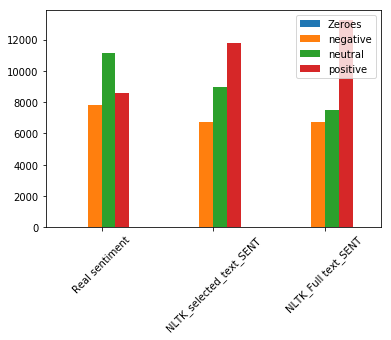

In [10]:
result.plot.bar(rot=45);

In [11]:
# selected text nltk sentiment match with competition sentiment
len(train[train['NLTK_selected_text_SENT'] ==train.sentiment])/len(train)

0.630757476533508

In [12]:
# full text nltk sentiment match with competition sentiment
len(train[train['NLTK_text_SENT'] ==train.sentiment])/len(train)

0.6337044313468675

In [13]:
(train[train['NLTK_text_SENT'] ==train.sentiment]).mean()

Series([], dtype: float64)

## Text blob

In [14]:
from textblob import TextBlob

def textblobpolar(row):
    # todo change treshhold
    
    polarity = TextBlob(row).sentiment.polarity
    
    if polarity >= 0.05:
        topSentiment = 'positive'
    elif polarity <= -0.05:
        topSentiment = 'negative'
    else:
        topSentiment = 'neutral'
    
    return topSentiment

In [15]:
%%time

train['TB_text_SENT'] = train['text'].apply(textblobpolar)  
train['TB_selected_text_SENT'] = train['selected_text'].apply(textblobpolar)

CPU times: user 35.6 s, sys: 11.7 ms, total: 35.6 s
Wall time: 35.6 s


In [16]:
frame = {'Real sentiment': train.sentiment.value_counts(),
         'NLTK_selected_text_SENT': train.NLTK_selected_text_SENT.value_counts(), 
         'NLTK_Full text_SENT': train.NLTK_text_SENT.value_counts(),
         
         'TB_selected_text_SENT': train.TB_selected_text_SENT.value_counts(),
         'TB_Full_text_SENT': train.TB_text_SENT.value_counts()
        } 
  
result = pd.DataFrame(frame).T

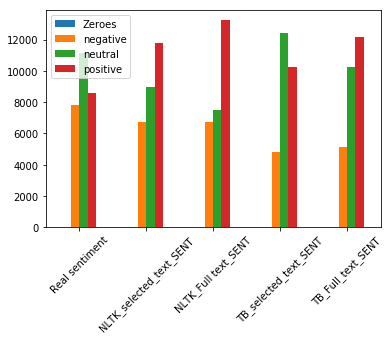

In [17]:
result.plot.bar(rot=45);

In [18]:
len(train[train['TB_selected_text_SENT'] ==train.sentiment])/len(train)

0.556865313250382

In [19]:
len(train[train['TB_text_SENT'] ==train.sentiment])/len(train)

0.588881612457251

# Flair

In [22]:
#!pip install flair;
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment');

2020-03-31 15:59:25,615 loading file /root/.flair/models/imdb-v0.4.pt


In [23]:
def flairSent(row,threshold=0.80):
    
    s = flair.data.Sentence(row)
    flair_sentiment.predict(s)
    topSentiment = s.labels[0].value
    score = s.labels[0].score
    
    if score < threshold:
        topSentiment = 'neutral'   
    elif topSentiment =='POSITIVE':
        topSentiment = 'positive'
    elif topSentiment == 'NEGATIVE' :
        topSentiment = 'negative'
    
    return topSentiment

In [24]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [25]:
%%time

#train['flair_text_SENT'] = train['text'].progress_apply(flairSent)  
train['flair_selected_text_SENT'] = train['selected_text'].progress_apply(flairSent,threshold=0.8)



CPU times: user 5h 16min 29s, sys: 32.2 s, total: 5h 17min 1s
Wall time: 2h 38min 33s


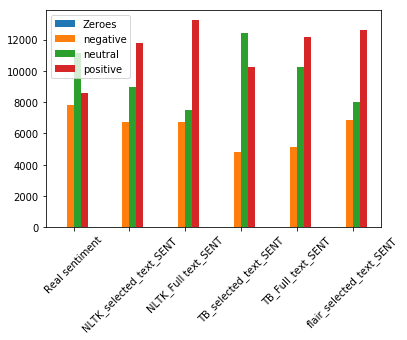

In [26]:
frame = {'Real sentiment': train.sentiment.value_counts(),
         'NLTK_selected_text_SENT': train.NLTK_selected_text_SENT.value_counts(), 
         'NLTK_Full text_SENT': train.NLTK_text_SENT.value_counts(),
         
         'TB_selected_text_SENT': train.TB_selected_text_SENT.value_counts(),
         'TB_Full_text_SENT': train.TB_text_SENT.value_counts(),
         
         'flair_selected_text_SENT': train.flair_selected_text_SENT.value_counts()
         #'flair_full_text_SENT': train.flair_text_SENT.value_counts()
         
        } 
  
result = pd.DataFrame(frame).T
result.plot.bar(rot=45);

In [27]:
len(train[train['flair_selected_text_SENT'] ==train.sentiment])/len(train)

0.36913337699192317

# Train sentiment classifier

## Naive bayes

In [28]:
X_train = train.text
y_train = train.sentiment

X_test = test.text
y_test = test.sentiment

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer, TfidfVectorizer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [30]:
%%time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=y_test.unique()))

accuracy 0.6254596888260254
              precision    recall  f1-score   support

    positive       0.79      0.37      0.50      1001
     neutral       0.53      0.87      0.66      1430
    negative       0.82      0.55      0.65      1104

    accuracy                           0.63      3535
   macro avg       0.71      0.59      0.61      3535
weighted avg       0.69      0.63      0.61      3535

CPU times: user 200 ms, sys: 5.66 ms, total: 206 ms
Wall time: 204 ms


# log reg

In [31]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression()),
               ])
logreg.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [32]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=y_test.unique()))

accuracy 0.7083451202263084
              precision    recall  f1-score   support

    positive       0.73      0.65      0.69      1001
     neutral       0.64      0.75      0.69      1430
    negative       0.80      0.71      0.75      1104

    accuracy                           0.71      3535
   macro avg       0.72      0.70      0.71      3535
weighted avg       0.72      0.71      0.71      3535

CPU times: user 273 ms, sys: 1.01 ms, total: 274 ms
Wall time: 271 ms


# LSVM

In [33]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=17, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [34]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=y_test.unique()))

accuracy 0.6854314002828854
              precision    recall  f1-score   support

    positive       0.74      0.56      0.64      1001
     neutral       0.63      0.72      0.67      1430
    negative       0.73      0.75      0.74      1104

    accuracy                           0.69      3535
   macro avg       0.70      0.68      0.68      3535
weighted avg       0.69      0.69      0.68      3535

CPU times: user 203 ms, sys: 6 µs, total: 203 ms
Wall time: 201 ms


# Keras BOW

In [35]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


In [36]:
%%time

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train.text) # only fit on train

x_train = tokenize.texts_to_matrix(train.text)
x_test = tokenize.texts_to_matrix(test.text)

encoder = LabelEncoder()
encoder.fit(train.sentiment)
y_train = encoder.transform(train.sentiment)
y_test = encoder.transform(test.sentiment)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 8

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 24737 samples, validate on 2749 samples
Epoch 1/8
24737/24737 [==============================] - 6s 229us/step - loss: 0.8311 - accuracy: 0.6254 - val_loss: 0.7611 - val_accuracy: 0.6773
Epoch 2/8
24737/24737 [==============================] - 5s 209us/step - loss: 0.6731 - accuracy: 0.7197 - val_loss: 0.7506 - val_accuracy: 0.6792
Epoch 3/8
24737/24737 [==============================] - 5s 218us/step - loss: 0.5920 - accuracy: 0.7564 - val_loss: 0.7710 - val_accuracy: 0.6959
Epoch 4/8
24737/24737 [==============================] - 5s 219us/step - loss: 0.4933 - accuracy: 0.7974 - val_loss: 0.8410 - val_accuracy: 0.6802
Epoch 5/8
24737/24737 [==============================] - 5s 212us/step - loss: 0.3991 - accuracy: 0.8404 - val_loss: 0.9337 - val_accuracy: 0.6781
Epoch 6/8
24737/24737 [==============================] - 5s 210us/step - loss: 0.3248 - accuracy: 0.8723 - val_loss: 1.0527 - val_accuracy: 0.6759
Epoch 7/8
24737/24737 [==============================] - 5s 211us/ste

In [37]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

3535/3535 [==============================] - 0s 50us/step
Test accuracy: 0.6859971880912781


In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(x_test)
y_pred = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_test = [np.argmax(y, axis=None, out=None) for y in y_test]

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=test.sentiment.unique()))

accuracy 0.685997171145686
              precision    recall  f1-score   support

    positive       0.68      0.61      0.64      1001
     neutral       0.63      0.73      0.68      1430
    negative       0.79      0.70      0.74      1104

    accuracy                           0.69      3535
   macro avg       0.70      0.68      0.69      3535
weighted avg       0.69      0.69      0.69      3535



# fast ai

In [39]:
from fastai import *
from fastai.text import *

In [40]:
train = train[['sentiment','text']]
#train.dropna(inplace=True)

test = test[['sentiment','text']]
#test.dropna(inplace=True)

In [41]:
data_lm = TextLMDataBunch.from_df('./', train, test,)

In [43]:
data_lm.vocab.itos[10:20]

['.', '!', 'to', 'the', ',', 'a', 'my', 'it', 'you', 'and']

In [44]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.5)

In [45]:
learn.predict('Im concerned', 5)

'Im concerned about you in any particular'

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


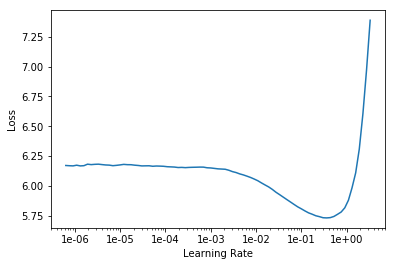

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,5.007874,3.835014,0.357143,13:05


In [48]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.367638,3.541579,0.414286,14:08
1,4.257082,3.507455,0.357143,14:15
2,4.028757,3.632752,0.385714,14:11
3,3.664956,3.673011,0.371429,14:10
4,3.251805,3.820475,0.371429,14:17


In [49]:
print(learn.predict('xxbos', n_words=5))

xxbos Just had some


In [50]:
# Save the encoder
learn.save_encoder('fine_enc')

## Train class

In [51]:
data_clas = TextClasDataBunch.from_df('./', train, test, vocab=data_lm.vocab, bs=32)

In [52]:
classifier = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
classifier.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (27486 items)
x: TextList
xxbos xxmaj spent the entire morning in a meeting w / a xxunk , and my boss was not happy w / them . xxmaj lots of fun . i had other plans for my morning,xxbos xxmaj oh ! xxmaj good idea about putting them on ice cream,xxbos says good ( or should i say bad ? ) afternoon ! http : / / plurk.com / p / xxunk,xxbos i do nt think you can vote anymore ! i tried,xxbos haha better drunken tweeting you mean ?
y: CategoryList
neutral,positive,neutral,negative,positive
Path: .;

Valid: LabelList (3535 items)
x: TextList
xxbos http : / / twitpic.com / xxunk - i wish i was calling you but i ca n't from xxmaj xxunk,xxbos i 'm xxunk . xxup house xxup md marathon xxunk,xxbos i 'm concerned for that family,xxbos xxup hey xxup guys xxup it xxup 's xxup working xxup no xxup need xxup to xxup worry . i have tooo many followers tho ...,xxbos xxunk xxmaj xxunk
y: CategoryList
positive,positive,positive,positive,neutral
Path: .;

T

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


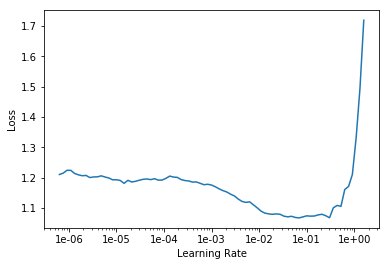

In [53]:
classifier.lr_find()
classifier.recorder.plot()

In [54]:
classifier.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.852901,0.783731,0.639887,14:30


In [55]:
preds, targets = classifier.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,537,207,62
1,396,1035,352
2,68,188,690


In [56]:
test.head()

,sentiment,text
0,positive,http://twitpic.com/67swx - i wish i was calli...
1,positive,i'm done.haha. HOUSE MD marathon ulet
2,positive,I'm concerned for that family
3,positive,HEY GUYS IT'S WORKING NO NEED TO WORRY. i have...
4,neutral,26th February


In [57]:
%%time
test['pred'] = test['text'].apply(lambda row: str(classifier.predict(row)[0]))

CPU times: user 29min 14s, sys: 1.38 s, total: 29min 15s
Wall time: 26min 9s


In [58]:
len(test[test['pred']==test['sentiment']])/len(test)

0.6396039603960396

In [59]:
test.pred.value_counts()

neutral     1780
positive     950
negative     805
Name: pred, dtype: int64

In [61]:
test.head()

,sentiment,text,pred
0,positive,http://twitpic.com/67swx - i wish i was calli...,neutral
1,positive,i'm done.haha. HOUSE MD marathon ulet,neutral
2,positive,I'm concerned for that family,positive
3,positive,HEY GUYS IT'S WORKING NO NEED TO WORRY. i have...,neutral
4,neutral,26th February,neutral
